In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import random




# Fix the true distribution (Finite, Discrete)

In [134]:
def get_true_dist(N):
  random.seed(10)
  # Mean vector
  mu = np.array([0.074, 0.309, 0.548])

  # Covariance matrix
  Sigma = np.array([[0.858, -0.139, -0.242],
                    [-0.139, 0.698, -0.136],
                    [-0.242, -0.136, 0.408]])


  samples = np.random.multivariate_normal(mu, Sigma, 50)
  e_0 = samples  # true distribution
  p_0 = np.ones(len(samples))/len(samples) # true distribution

  return (e_0,p_0)

# Generate Distribution within phi divergence

In [136]:
def get_ds(S,eta):
  d = np.random.normal(size = S)
  d = d-np.mean(d)
  scale = sum(d**2)/(eta**2/S)
  d = d/np.sqrt(scale)
  return d

def get_Qs(values,M,eta):
  '''
  values: True distribution is uniform over these points
  M: Number of Q's to generate
  eta: phi divergence radius

  Returns a list of Q's. Each Q is a list of probabilities, on the same set of points as values
  '''
  S = len(values)
  P = [1/S]*S
  Qs = [P + get_ds(S,eta) for i in range(M)]
  return Qs

In [68]:
# sanity checks
S = len(e_0)
P = [1/S]*S

Qs = get_Qs(e_0,5,0.001)
Qs[0].sum()

1.0

In [69]:
# sanity checks
((Qs[0] - P)**2/P).sum()

1.0000000000000108e-06

In [70]:
N = 100 # Number of Qs to geerate
eta = 0.2

Qs = get_Qs(e_0,N,eta)

## Get optimal solution

given $Q$, obtain $x^*(Q)$

  - $Q$ is characterized by $(e,p)$
  - $e$ is the set of points in the support of $Q$ (same as base $e_0$)
  - $p$ is the corresponding probabilities

In [71]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function
def objective(theta, p, e):
    # Compute the objective function efficiently using vectorized operations
    exp_terms = np.exp(-np.dot(e, theta))  # e_i^T * theta for all i
    return np.dot(p, exp_terms)  # Weighted sum by p

# Constraint: sum(theta) = 1
def constraint_sum(theta):
    return np.sum(theta) - 1

# Bounds for theta (theta_i >= 0)
def create_bounds(n):
    return [(0, None) for _ in range(n)]

# Fast implementation using vectorized operations
def optima(p, e):
    n = e.shape[1]  # Dimension of theta
    theta_initial = np.ones(n) / n  # Initial guess: uniform distribution

    # Define the constraints and bounds
    constraints = {'type': 'eq', 'fun': constraint_sum}
    bounds = create_bounds(n)

    # Perform the optimization using SLSQP
    result = minimize(objective, theta_initial, args=(p, e), method='SLSQP', bounds=bounds, constraints=[constraints])

    return result.x, result.fun

# Example parameters
p = np.array([0.3, 0.5, 0.2])  # Probabilities p_i
e = np.array([[1, 0], [0, 1], [1, 1]])  # Vectors e_i (arbitrary vectors in R^n)

# Run the fast implementation
optimal_theta, optimal_value = optima(p, e)

print("Optimal theta:", optimal_theta)
print("Optimal objective value:", optimal_value)


Optimal theta: [0.24461064 0.75538936]
Optimal objective value: 0.5433925171697135


In [72]:
p = Qs[0]  # Probabilities p_i
e = e_0  # Vectors e_i (arbitrary vectors in R^n)

# Run the fast implementation
optimal_theta, optimal_value = optima(p, e)

print("Optimal theta:", optimal_theta)
print("Optimal objective value:", optimal_value)


Optimal theta: [0.         0.26897418 0.73102582]
Optimal objective value: 0.6111620189268351


## Get optimals



In [73]:
def get_optimals(Qs, e):
  '''
  Qs: list of Q's
  e: support of Q (assumed same for all the Q's)
  returns: list of optimal loss
  '''
  return np.array([optima(Q, e)[1] for Q in Qs])

# check
A = get_optimals(Qs, e_0)
np.round((A.mean(),A.std()),6)

array([0.613973, 0.007397])

### Evaluate Regret

  - We have a vector of decisions xs (length k)
  - We have a list of Qs (length l)
  - $e$ is the finite support of the distributions
  - Return matrix ($k\times l$) with regret of each $(x,Q)$ pair



In [94]:
def get_regrets(xs, Qs, e):
  k = len(xs)
  l = len(Qs)
  A = get_optimals(Qs, e_0)
  out =  [[(objective(x,Qs[i],e) - A[i]) for x in xs] for i in range(l)]
  return pd.DataFrame(out, columns = [f'x{i}' for i in range(k)])


In [96]:
# Check

xs = [optima(p_0,e_0)[0], optima(Qs[0],e_0)[0]]
get_regrets(xs, Qs, e_0).head()

,x0,x1
0,0.000406,0.000000
1,0.000270,0.000014
2,0.000933,0.000111
3,0.000607,0.002094
4,0.000335,0.000003


## KL-DRO solution

In [101]:
import numpy as np
from scipy.optimize import minimize

# Conjugate function φ*(s) = -log(1 - s) for s < 1, applied element-wise
def phi_star(s):
    # Apply a heavy penalty for s >= 1
    penalty = 1e10  # Large penalty for invalid s
    return np.where(s < 1,  -np.log(1 - s),penalty)

# Define the objective function for the DRO problem
def objective_dro(vars, xi_values, lambda_, n):
    x = vars[:-2]  # Decision variable x
    alpha = vars[-2]  # Dual variable α
    beta = vars[-1]   # Dual variable β

    if alpha <= 0:
        return np.inf  # α must be non-negative

    # Compute h(x, ξi) = exp(-x^T ξi) for all ξi
    h_xi = np.exp(-xi_values.dot(x))  # shape: (n,)

    # Compute s = (h(x, ξi) - β) / α for all ξi
    s = (h_xi - beta) / alpha
    if max(s) >= 1:
        return np.inf  # s must be < 1

    # Apply the conjugate function φ*(s) for all s
    sum_term = np.sum(phi_star(s))

    # Full objective function
    return alpha * (sum_term / n) + alpha * lambda_ + beta

# Constraint: α must be non-negative
def constraint_alpha(vars):
    alpha = vars[-2]
    return alpha



# New constraint: sum of x must equal 1
def constraint_sum_to_one(vars):
    x = vars[:-2]  # Decision variable x
    return np.sum(x) - 1

# DRO solver function with positivity and sum-to-one constraints
def dro_solution(xi_values, lambda_):
    n, d = xi_values.shape  # n = number of data points, d = dimension of each data point ξi

    # Initial guess for x, α, and β
    x_init = EO_solution(xi_values)  # Random initial guess for x, ensuring positivity
    x_init = x_init / np.sum(x_init)  # Normalize to sum to 1
    alpha_init = 1.0  # Initial guess for α

    h_xi = np.exp(-xi_values.dot(x_init))  # shape: (n,)

    # Compute s = (h(x, ξi) - β) / α for all ξi


    beta_init = max(h_xi)   # Initial guess for β

    initial_guess = np.hstack([x_init, alpha_init, beta_init])

    # Define the bounds (x_i ≥ 0 and α ≥ 0)
    bounds = [(0, None)] * d + [(0, None), (None, None)]

    # Define the constraints for α ≥ 0 and sum of x = 1
    constraints = [
        {'type': 'ineq', 'fun': constraint_alpha},   # α ≥ 0
        {'type': 'eq', 'fun': constraint_sum_to_one} # sum(x) = 1
    ]

    # Solve the optimization problem using 'SLSQP'
    result = minimize(objective_dro, initial_guess, args=(xi_values, lambda_, n),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    x_opt = result.x[:-2]
    alpha_opt = result.x[-2]
    beta_opt = result.x[-1]
    return x_opt

def EO_solution(xi_values):
  e_new = xi_values
  p_new = np.ones(len(e_new))/len(e_new)
  EO, _ = optima(p_new, e_new)
  return EO

In [98]:
# check
EO_solution(e_0)

array([0.        , 0.29798314, 0.70201686])

In [100]:
dro_solution(e_0, 0.0001)

array([0.        , 0.30261343, 0.69738657])

## Test Single Run

In [105]:
## get data from ground truth

n = 100 # sample size of data
EOs = []
for i in range(100):
  n = (i+10)*50
  indices = np.random.choice(len(e_0), n, replace=True)
  e_new = e_0[indices]
  p_new = np.ones(len(e_new))/len(e_new)

  EO, _ = optima(p_new, e_new)
  EOs.append(EO)

out = get_regrets(EOs, [p_0], e_0)

<Axes: >

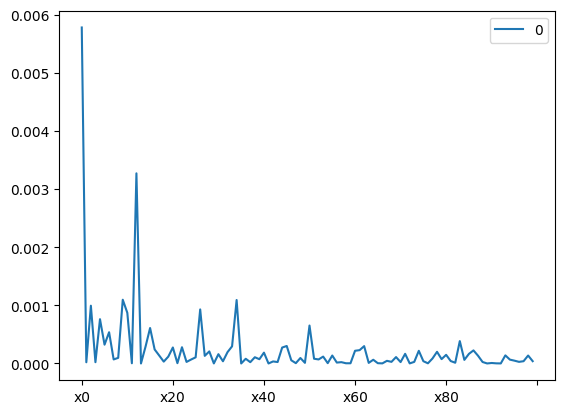

In [111]:
# Regret of EO at the true distrbution for increasing datasize
out.T.plot()

## First consider a bunch of data sets.

For Each, evaluate an $x^{EO}$ and $x^{DRO}$.

In [114]:
import numpy as np
import pandas as pd


def evaluate_solutions(N, n, lambda_, e_0):
    # Initialize empty lists to store the outputs for dro_solution and EO_solution
    dro_outputs = []
    EO_outputs = []

    for _ in range(N):
        # Sample xi_values from e_0 with replacement
        indices = np.random.choice(len(e_0), n, replace=True)
        xi_values = e_0[indices]

        # Evaluate dro_solution and EO_solution
        dro_output = dro_solution(xi_values, lambda_)
        EO_output = EO_solution(xi_values)

        # Append the outputs to their respective lists
        dro_outputs.append(dro_output)
        EO_outputs.append(EO_output)

    # Convert the lists of outputs into dataframes
    #dro_df = pd.DataFrame(dro_outputs, columns=[f'dro_{i}' for i in range(len(dro_outputs[0]))])
    #EO_df = pd.DataFrame(EO_outputs, columns=[f'EO_{i}' for i in range(len(EO_outputs[0]))])

    return dro_outputs, EO_outputs


In [126]:
# Check

N = 200 # Number of datasets
n = 200 # sample size of data
lambda_ = 0.0001

DRO_sols, EO_sols  = evaluate_solutions(N, n, lambda_, e_0)

## Max (Test)
Need: $max_Q E[R(x,Q)]$

For each $Q$, evaluate $E[R(x,Q)]$. Then take max.

### EO

In [128]:
Mat = get_regrets(EO_sols, Qs, e_0)

Mat.shape

(100, 200)

In [131]:
Expectations = Mat.mean(axis = 1)
max(Expectations)

0.005533912062777717

# Single Run

### Parameters:
  - $\gamma_{\lambda}$, $\kappa_{\lambda}$:   Control relative growths of $(n, \lambda_n)$.  
  - $\gamma_{\eta}$, $\kappa_{\eta}$:   Control relative growths of $(n, \eta_n)$.  
  - N:  Number of data sets to estimate Expectation
  - M:  Number of Qs to take maximum over

### Scheme:
We have $(n, \eta_n, \lambda_n)$.   
Consider $n\in [100, 500, 1000, 1500, 2000]$.    
output: a single vector, representing max expected regret at each n.  


For each n:

  - Create M Qs within $\eta_n$ divergence of $e_0$
  - Create N datasets. For each data, evaluate $x^{EO}$, $x^{DRO}_{\lambda_n}$.
  - Create the two $M\times N$ matrix of regrets
  - Take Expectation over N, then Max over M

In [171]:
def Single_Run(ns, G_l, K_l, G_e, K_e, N, M, e_0):
  lambdas = (G_l/(ns**K_l))**2
  etas = G_e/(ns**K_e)
  Ss = 1/np.sqrt(ns)+etas
  l = len(ns)
  outs = []
  for i in range(l):
    n = ns[i]
    lambda_ = lambdas[i]
    eta = etas[i]
    s = Ss[i]

    print('n ,lambda_, eta, s = ',np.round([n,lambda_, eta, s],6))

    Qs = get_Qs(e_0,M,eta)

    DRO_sols, EO_sols = evaluate_solutions(N, n, lambda_, e_0)

    DRO_Mat = get_regrets(DRO_sols, Qs, e_0)/(s**2)
    EO_Mat = get_regrets(EO_sols, Qs, e_0)/(s**2)

    DRO_Expectations = DRO_Mat.mean(axis = 1)
    EO_Expectations = EO_Mat.mean(axis = 1)

    # print(DRO_Expectations.shape) # should be M
    # print(EO_Expectations.shape)

    max_DRO = DRO_Expectations.max()
    max_EO = EO_Expectations.max()

    outs.append([max_DRO, max_EO])
  return pd.DataFrame(outs, columns = ['DRO', 'EO'], index = ns)



In [178]:
G_l, K_l = 0.5, 1
G_e, K_e = 0.5, 1

N = 100
M = 201 # kept different for sanity checks

ns = 100*(np.array(range(10))+ 1)

out = Single_Run(ns , G_l, K_l, G_e, K_e, N, M, e_0)

n ,lambda_, eta, s =  [1.00e+02 2.50e-05 5.00e-03 1.05e-01]
n ,lambda_, eta, s =  [2.0000e+02 6.0000e-06 2.5000e-03 7.3211e-02]
n ,lambda_, eta, s =  [3.0000e+02 3.0000e-06 1.6670e-03 5.9402e-02]
n ,lambda_, eta, s =  [4.000e+02 2.000e-06 1.250e-03 5.125e-02]
n ,lambda_, eta, s =  [5.0000e+02 1.0000e-06 1.0000e-03 4.5721e-02]
n ,lambda_, eta, s =  [6.0000e+02 1.0000e-06 8.3300e-04 4.1658e-02]
n ,lambda_, eta, s =  [7.0000e+02 1.0000e-06 7.1400e-04 3.8511e-02]
n ,lambda_, eta, s =  [8.000e+02 0.000e+00 6.250e-04 3.598e-02]
n ,lambda_, eta, s =  [9.0000e+02 0.0000e+00 5.5600e-04 3.3889e-02]
n ,lambda_, eta, s =  [1.0000e+03 0.0000e+00 5.0000e-04 3.2123e-02]


In [180]:
G_l, K_l = 0.5, 1
G_e, K_e = 0.5, 1

N = 100
M = 101 # kept different for sanity checks

ns = 100*(np.array(range(10))+ 1)

out = Single_Run(ns , G_l, K_l, G_e, K_e, N, M, e_0)

n ,lambda_, eta, s =  [1.00e+02 2.50e-05 5.00e-03 1.05e-01]
n ,lambda_, eta, s =  [2.0000e+02 6.0000e-06 2.5000e-03 7.3211e-02]
n ,lambda_, eta, s =  [3.0000e+02 3.0000e-06 1.6670e-03 5.9402e-02]
n ,lambda_, eta, s =  [4.000e+02 2.000e-06 1.250e-03 5.125e-02]
n ,lambda_, eta, s =  [5.0000e+02 1.0000e-06 1.0000e-03 4.5721e-02]
n ,lambda_, eta, s =  [6.0000e+02 1.0000e-06 8.3300e-04 4.1658e-02]
n ,lambda_, eta, s =  [7.0000e+02 1.0000e-06 7.1400e-04 3.8511e-02]
n ,lambda_, eta, s =  [8.000e+02 0.000e+00 6.250e-04 3.598e-02]
n ,lambda_, eta, s =  [9.0000e+02 0.0000e+00 5.5600e-04 3.3889e-02]
n ,lambda_, eta, s =  [1.0000e+03 0.0000e+00 5.0000e-04 3.2123e-02]


<Axes: >

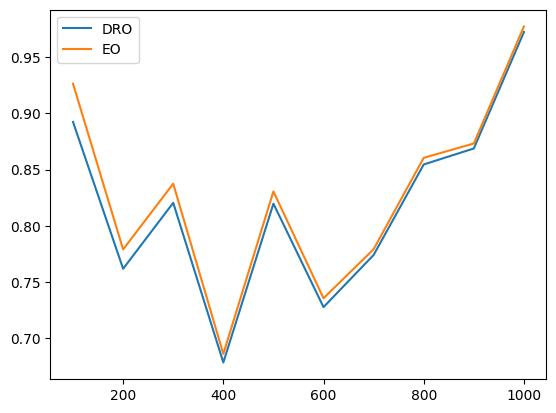

In [181]:
out.plot()

# Everything in one cell

Base true distribution: Uniform over $e_0$

